In [20]:
import ast
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
import seaborn as sns

In [ ]:
class MLPForCombinedPredictions(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_labels):
        super(MLPForCombinedPredictions, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, num_labels),
            nn.Softmax(dim=-1)  
        )
    
    def forward(self, x):
        return self.mlp(x)

In [ ]:
class EmotionDataset(Dataset):
    def __init__(self, data):
        """
        Args:
            data: DataFrame containing the data.
        """
        self.data = data
        self.label_order = ['fear', 'disgust', 'joy', 'surprise', 'sadness', 'anger']

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]

        def extract_probs(column):
            prob_dict = dict(ast.literal_eval(row[column]))
            return [prob_dict[label] for label in self.label_order]

        image_probs = torch.tensor(extract_probs('clip_predictions'), dtype=torch.float32)
        text_probs = torch.tensor(extract_probs('mapped_predictions'), dtype=torch.float32)
        labels = torch.tensor(extract_probs('averaged_predictions'), dtype=torch.float32)

        combined_features = torch.cat((image_probs, text_probs), dim=0)
        return combined_features, labels

In [ ]:
def train_mlp(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for features, labels in dataloader:
        features, labels = features.to(device), labels.to(device)
        
        optimizer.zero_grad()
        predictions = model(features)
        loss = criterion(torch.log(predictions), labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

def evaluate_model(model, dataloader, device):
    model.eval()
    total_kl_div = 0.0
    total_cosine_sim = 0.0
    total_mse = 0.0
    num_samples = 0

    with torch.no_grad():
        for features, labels in dataloader:
            features, labels = features.to(device), labels.to(device)
            predictions = model(features)

            total_kl_div += F.kl_div(torch.log(predictions), labels, reduction='batchmean').item() * len(features)
            total_cosine_sim += F.cosine_similarity(predictions, labels, dim=-1).mean().item() * len(features)
            total_mse += F.mse_loss(predictions, labels, reduction='mean').item() * len(features)
            num_samples += len(features)

    avg_kl_div = total_kl_div / num_samples
    avg_cosine_sim = total_cosine_sim / num_samples
    avg_mse = total_mse / num_samples

    return avg_kl_div, avg_cosine_sim, avg_mse

def plot_cosine_similarity_kde(predictions, labels):
    """
    Compute and visualize the distribution of cosine similarities using a KDE plot.
    Args:
        predictions: Tensor of predicted probabilities (batch_size, num_labels).
        labels: Tensor of true probabilities (batch_size, num_labels).
    """
    similarities = F.cosine_similarity(predictions, labels, dim=-1).detach().cpu().numpy()

    plt.figure(figsize=(8, 6))
    sns.kdeplot(similarities, fill=True, color="blue")
    plt.title("Cosine Similarity Distribution")
    plt.xlabel("Cosine Similarity")
    plt.ylabel("Density")
    plt.axvline(x=1.0, color='green', linestyle='--', label='Perfect Similarity')
    plt.legend()
    plt.show()



In [29]:
def plot_label_wise_heatmap(predictions, labels, label_order):
    """
    Plot a heatmap comparing average predicted vs actual probabilities for each label.
    """
    # Aggregate probabilities across all samples
    avg_pred = predictions.mean(dim=0).detach().cpu().numpy()
    avg_label = labels.mean(dim=0).cpu().numpy()

    # Prepare data for heatmap
    heatmap_data = np.vstack([avg_label, avg_pred])
    labels = ["True", "Predicted"]

    # Create heatmap
    plt.figure(figsize=(10, 4))
    sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="coolwarm", xticklabels=label_order, yticklabels=labels)
    plt.title("Label-Wise Average Probabilities")
    plt.xlabel("Labels")
    plt.ylabel("Distribution")
    plt.show()
    



In [34]:
import random

def print_random_predictions(predictions, labels, label_order, num_samples=5):
    """
    Print a few random predictions and their corresponding true labels.
    Args:
        predictions: Tensor of predicted probabilities (batch_size, num_labels).
        labels: Tensor of true probabilities (batch_size, num_labels).
        label_order: List of labels in the correct order.
        num_samples: Number of random samples to display.
    """
    # Convert predictions and labels to numpy arrays
    predictions = predictions.detach().cpu().numpy()
    labels = labels.cpu().numpy()

    # Randomly select sample indices
    indices = random.sample(range(len(predictions)), num_samples)

    for idx in indices:
        print(f"Sample {idx + 1}")
        print("True Labels:")
        for label, prob in zip(label_order, labels[idx]):
            print(f"  {label}: {prob:.4f}")
        print("Predicted Labels:")
        for label, prob in zip(label_order, predictions[idx]):
            print(f"  {label}: {prob:.4f}")
        print("-" * 40)

Epoch 1/5, Train Loss: 0.4421, Validation KL Divergence: 0.3669
Epoch 2/5, Train Loss: 0.3710, Validation KL Divergence: 0.3443
Epoch 3/5, Train Loss: 0.3568, Validation KL Divergence: 0.3404
Epoch 4/5, Train Loss: 0.3504, Validation KL Divergence: 0.3415
Epoch 5/5, Train Loss: 0.3482, Validation KL Divergence: 0.3393
Test KL Divergence: 0.3342, Cosine Similarity: 0.7994, MSE: 0.0224


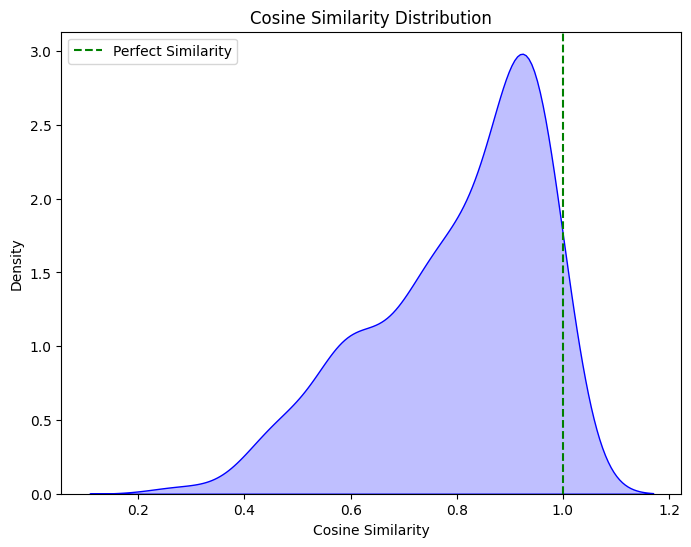

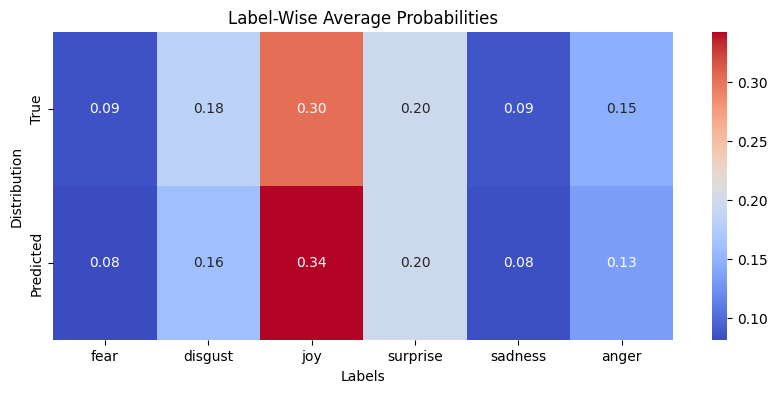

In [36]:
file_path = "/work/ptyagi/masterthesis/data/predictions/averaged_predictions.csv" 

data = pd.read_csv(file_path)
    
train_data, temp_data = train_test_split(data, test_size=0.3, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=1/3, random_state=42)

train_dataset = EmotionDataset(train_data)
val_dataset = EmotionDataset(val_data)
test_dataset = EmotionDataset(test_data)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

num_labels = 6  
input_dim = num_labels * 2  
hidden_dim = 128

device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
model = MLPForCombinedPredictions(input_dim=input_dim, hidden_dim=hidden_dim, num_labels=num_labels).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.KLDivLoss(reduction="batchmean")

epochs = 5
for epoch in range(epochs):
    train_loss = train_mlp(model, train_loader, optimizer, criterion, device)
    val_loss = evaluate_model(model, val_loader, device)
    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Validation KL Divergence: {val_loss[0]:.4f}")

avg_kl_div, avg_cosine_sim, avg_mse = evaluate_model(model, test_loader, device)
print(f"Test KL Divergence: {avg_kl_div:.4f}, Cosine Similarity: {avg_cosine_sim:.4f}, MSE: {avg_mse:.4f}")

all_predictions = []
all_labels = []

for features, labels in test_loader:
    features, labels = features.to(device), labels.to(device)
    predictions = model(features)
    all_predictions.append(predictions)
    all_labels.append(labels)

all_predictions = torch.cat(all_predictions, dim=0)
all_labels = torch.cat(all_labels, dim=0)

plot_cosine_similarity_kde(all_predictions, all_labels)
plot_label_wise_heatmap(all_predictions, all_labels, train_dataset.label_order)


In [37]:
print_random_predictions(all_predictions, all_labels, train_dataset.label_order, num_samples=1)

Sample 56
True Labels:
  fear: 0.0608
  disgust: 0.2177
  joy: 0.3304
  surprise: 0.0811
  sadness: 0.0518
  anger: 0.2582
Predicted Labels:
  fear: 0.0611
  disgust: 0.1174
  joy: 0.4579
  surprise: 0.1883
  sadness: 0.0738
  anger: 0.1015
----------------------------------------


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from transformers import BertModel, BertTokenizer

class MultimodalModel(nn.Module):
    def __init__(self, image_model_output_dim, text_model_output_dim, mlp_hidden_dim, num_labels):
        super(MultimodalModel, self).__init__()
        # Image model
        self.image_model = models.resnet50(pretrained=True)
        self.image_model.fc = nn.Identity()  # Remove classification head
        self.image_output_dim = image_model_output_dim
        
        # Text model
        self.text_model = BertModel.from_pretrained("bert-base-uncased")
        self.text_output_dim = text_model_output_dim
        
        # MLP for final predictions
        self.mlp = nn.Sequential(
            nn.Linear(self.image_output_dim + self.text_output_dim, mlp_hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(mlp_hidden_dim, num_labels),
            nn.Softmax(dim=-1)  # Output probabilities
        )
    
    def forward(self, images, input_ids, attention_mask):
        # Image features
        image_features = self.image_model(images)  # Shape: (batch_size, image_output_dim)
        
        # Text features
        text_outputs = self.text_model(input_ids=input_ids, attention_mask=attention_mask)
        text_features = text_outputs.pooler_output  # Shape: (batch_size, text_output_dim)
        
        # Concatenate features
        combined_features = torch.cat((image_features, text_features), dim=1)
        
        # Final predictions
        predictions = self.mlp(combined_features)
        return predictions  # Shape: (batch_size, num_labels)

# Number of labels
num_labels = 6

# Instantiate model
model = MultimodalModel(image_model_output_dim=2048, text_model_output_dim=768, mlp_hidden_dim=512, num_labels=num_labels)

In [ ]:
# Loss function
criterion = nn.KLDivLoss(reduction="batchmean")

# Example ground truth (batch of 8)
ground_truth = torch.tensor([
    [0.052, 0.089, 0.564, 0.123, 0.136, 0.034],
    [0.1, 0.2, 0.3, 0.1, 0.2, 0.1],
    # Add more examples here
], dtype=torch.float32)

# Normalize ground truth if not already
ground_truth = F.softmax(ground_truth, dim=-1)

# Forward pass (example inputs)
outputs = model(images, input_ids, attention_mask)  # Shape: (batch_size, num_labels)

# Compute loss
loss = criterion(torch.log(outputs), ground_truth)  # Log of outputs for KLDivLoss

In [ ]:
# Example of extracting individual predictions
image_probs = F.softmax(image_features, dim=-1)  # Shape: (batch_size, num_labels)
text_probs = F.softmax(text_features, dim=-1)   # Shape: (batch_size, num_labels)

# MLP combines these for the final prediction
final_probs = outputs  # Already softmaxed in the MLP output

In [ ]:
labels = ['fear', 'disgust', 'joy', 'surprise', 'sadness', 'anger']
batch_predictions = [
    list(zip(labels, probs.tolist()))
    for probs in final_probs
]

# Example output for one instance:
print(batch_predictions[0])
# [('fear', 0.05), ('disgust', 0.08), ('joy', 0.56), ('surprise', 0.12), ('sadness', 0.13), ('anger', 0.03)]